# Visualizing modeles, data, and training with TensorBoard

In the 60 Minute Blitz, we show you how to load in data, feed it through a model we define as a subclass of nn.Module, train this model on training data, and test it on test data. To see what’s happening, we print out some statistics as the model is training to get a sense for whether training is progressing. However, we can do much better than that: PyTorch integrates with TensorBoard, a tool designed for visualizing the results of neural network training runs. This tutorial illustrates some of its functionality, using the Fashion-MNIST dataset which can be read into PyTorch using torchvision.datasets.

In this tutorial, we’ll learn how to:

1. Read in data and with appropriate transforms (nearly identical to the prior tutorial).
2. Set up TensorBoard.
3. Write to TensorBoard.
4. Inspect a model architecture using TensorBoard.
5. Use TensorBoard to create interactive versions of the visualizations we created in last tutorial, with less code

Specifically, on point #5, we’ll see:

- A couple of ways to inspect our training data
- How to track our model’s performance as it trains
- How to assess our model’s performance once it is trained.

We’ll begin with similar boilerplate code as in the CIFAR-10 tutorial:

In [1]:
import matplotlib.pyplot as plt 
import numpy as np 

import torch
import torchvision
import torchvision.transforms as transforms 

import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 

# transforms 
transform = transforms.Compose(
    [transforms.ToTensor(), 
     transforms.Normalize((0.5, ), (0.5, ))
    ]
)

# daatasets 
trainset = torchvision.datasets.FashionMNIST(
    './data', 
    download=True, 
    train=True, 
    transform=transform
)

testset = torchvision.datasets.FashionMNIST(
    './data', 
    download=True, 
    train=False, 
    transform=transform
)

# dataloaders

trainloader = torch.utils.data.DataLoader(
    trainset, 
    batch_size=4, 
    shuffle=True, 
    num_workers=2
)

testloader = torch.utils.data.DataLoader(
    testset, 
    batch_size=4, 
    shuffle=False, 
    num_workers=2
)

# constant for classes
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# helper function to show an image
# (used in the `plot_classes_preds` function below)
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

We’ll define a similar model architecture from that tutorial, making only minor modifications to account for the fact that the images are now one channel instead of three and 28x28 instead of 32x32:

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

We’ll define the same optimizer and criterion from before:

In [3]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## 1. TensorBoard setup

Now we’ll set up TensorBoard, importing tensorboard from torch.utils and defining a SummaryWriter, our key object for writing information to TensorBoard.

In [4]:
from torch.utils.tensorboard import SummaryWriter

# defalt "log_dir" is "runs", but we'll be more specific here...
# ... this line alone creates a runs/fashion_mnist_test_1 folder
writer = SummaryWriter('runs/fashion_mnist_test_1')

## 2. Writing to TensorBoard

Now let’s write an image to our TensorBoard - specifically, a grid - using `make_grid`.

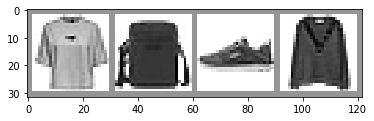

In [5]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
writer.add_image('four_fashion_mnist_images', img_grid)